<a href="https://colab.research.google.com/github/p25-c4/kerly_project/blob/main/0315_HY_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!nvidia-smi

Fri Mar 15 13:32:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/BigData/early_project")

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 한글폰트 설정
mpl.rc("font",family = "NanumGothic")
mpl.rc("axes", unicode_minus = False)

# Data load

In [5]:
# 파일 불러오는 코드
import pandas as pd
import zipfile
import io

# ZIP 파일 경로
zip_file_path = 'kurly.zip'
# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path) as z:
    # ZIP 파일 내에서 'total.csv' 찾기
    with z.open('kurly.csv') as csv_file:
        # CSV 파일을 Pandas DataFrame으로 읽기
        order_user_item = pd.read_csv(csv_file)

In [9]:
# OrderDT 열을 datetime 객체로 변환
order_user_item['OrderDT'] = pd.to_datetime(order_user_item['OrderDT'], format='%Y-%m-%d %H:%M:%S')

# datetime 객체에서 년을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Year'] = order_user_item['OrderDT'].dt.year
# datetime 객체에서 월을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Month'] = order_user_item['OrderDT'].dt.month
# datetime 객체에서 일을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Day'] = order_user_item['OrderDT'].dt.day
# datetime 객체에서 시를 추출하여 새로운 컬럼 Month에 저장
order_user_item['Hour'] = order_user_item['OrderDT'].dt.hour


---

# RFM (고객 세분화 분석)

In [10]:
# 원본 데이터셋 복사
rfm_online_sales =  order_user_item.copy()

# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['OrderDT'].max()

In [11]:
# Recency 계산
recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days
recency_data

,idUser,OrderDT,Recency
0,U10001,2023-12-27 08:25:54,4
1,U10002,2023-12-06 10:16:48,25
2,U10003,2023-12-23 21:09:58,8
3,U10004,2023-12-05 20:24:04,26
4,U10005,2023-11-20 12:40:36,41
...,...,...,...
2995,U12996,2023-12-29 18:56:12,2
2996,U12997,2023-12-26 20:27:53,5
2997,U12998,2023-11-27 19:51:55,34
2998,U12999,2023-12-27 10:22:26,4


In [12]:
# Frequency 계산
frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)
frequency_data

,idUser,Frequency
0,U10001,69
1,U10002,54
2,U10003,53
3,U10004,33
4,U10005,79
...,...,...
2995,U12996,20
2996,U12997,67
2997,U12998,56
2998,U12999,55


In [13]:
rfm_online_sales.head()

,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,...,Date,Year,Month,Day,Hour,CleanedItemName,TimeBetweenOrders,Combined,Weekday,WeekdayName
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,...,2021-12-03,2021,12,3,20,이츠웰 후르츠칵테일 과일통조림 3k 슬라이스,3 days 09:06:40,"20s, 여성, 2",4,Friday
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,...,2021-12-03,2021,12,3,20,베지가든 수제교자만두 매콤한 김치맛 720g 360gx2개입,3 days 09:06:40,"20s, 여성, 2",4,Friday
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,...,2021-12-03,2021,12,3,20,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,3 days 09:06:40,"20s, 여성, 2",4,Friday
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,...,2021-12-03,2021,12,3,20,계양구 배달 싱싱한 방울토마토 750g 작전 과일나라,3 days 09:06:40,"20s, 여성, 2",4,Friday
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,...,2021-12-03,2021,12,3,20,낙지호롱 900g 20 25개 낙지꼬치구이 냉동낙지 양념소스70gx1팩 제공,3 days 09:06:40,"20s, 여성, 2",4,Friday


In [14]:
# Monetary 계산
monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)
monetary_data

,idUser,Monetary
0,U10001,5968480
1,U10002,4595890
2,U10003,5110930
3,U10004,2641890
4,U10005,6920530
...,...,...
2995,U12996,2256990
2996,U12997,5999100
2997,U12998,5318240
2998,U12999,5321330


In [15]:
# RFM 데이터 결합
rfm_data = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

# Recency, Frequency, Monetary에 점수 부여
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 4, labels=[4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 4, labels=[1, 2, 3, 4])

# RFM 스코어 계산
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

In [16]:
# 고객 세그먼트 분류 함수
def classify_customer_segment(row):
    R, F, M = row['R_Score'], row['F_Score'], row['M_Score']

    if R == 4 and F == 4 and M == 4:
        return 'VIP고객'
    elif R >= 2 and F >= 3 and M == 4:
        return '충성고객'
    elif R >= 3 and F <= 3 and M <= 3:
        return '잠재충성고객'
    elif R == 2 and F < 2 and M < 2:
        return '신규고객'
    elif R >= 3 and F < 2 and M < 2:
        return '정체고객'
    elif R >= 3 and F >= 3 and M >= 3:
        return '관심필요고객'
    elif 2 <= R <= 3 and F < 3 and M < 3:
        return '잠드려는고객'
    elif R < 3 and 2 <= F <= 4 and 2 <= M <= 4:
        return '이탈우려고객'
    elif R < 2 and F == 4 and M == 4:
        return '놓치면안될고객'
    elif 2 <= R <= 3 and 2 <= F <= 3 and 2 <= M <= 3:
        return '겨울잠고객'
    elif R < 2 and F < 2 and M < 2:
        return '이탈고객'
    else:
        return '기타'


In [17]:
# rfm_data에 'Customer_Segment' 컬럼 추가
rfm_data['Customer_Segment'] = rfm_data.apply(classify_customer_segment, axis=1)

# 가능한 모든 세그먼트 정의
all_segments = ['VIP고객', '충성고객', '잠재충성고객', '신규고객', '정체고객', '관심필요고객',
                '잠드려는고객', '이탈우려고객', '놓치면안될고객', '겨울잠고객', '이탈고객', '기타']

# 각 세그먼트별 고객 수 계산
segment_counts = rfm_data['Customer_Segment'].value_counts()

# 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
segment_counts_all = {segment: 0 for segment in all_segments}
segment_counts_all.update(segment_counts)

# 데이터프레임으로 변환
segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])

segment_counts_df.sort_values(by='Count', ascending=False)

,Segment,Count
2,잠재충성고객,1087
7,이탈우려고객,698
1,충성고객,407
0,VIP고객,202
10,이탈고객,176
6,잠드려는고객,169
3,신규고객,157
11,기타,53
5,관심필요고객,51
4,정체고객,0


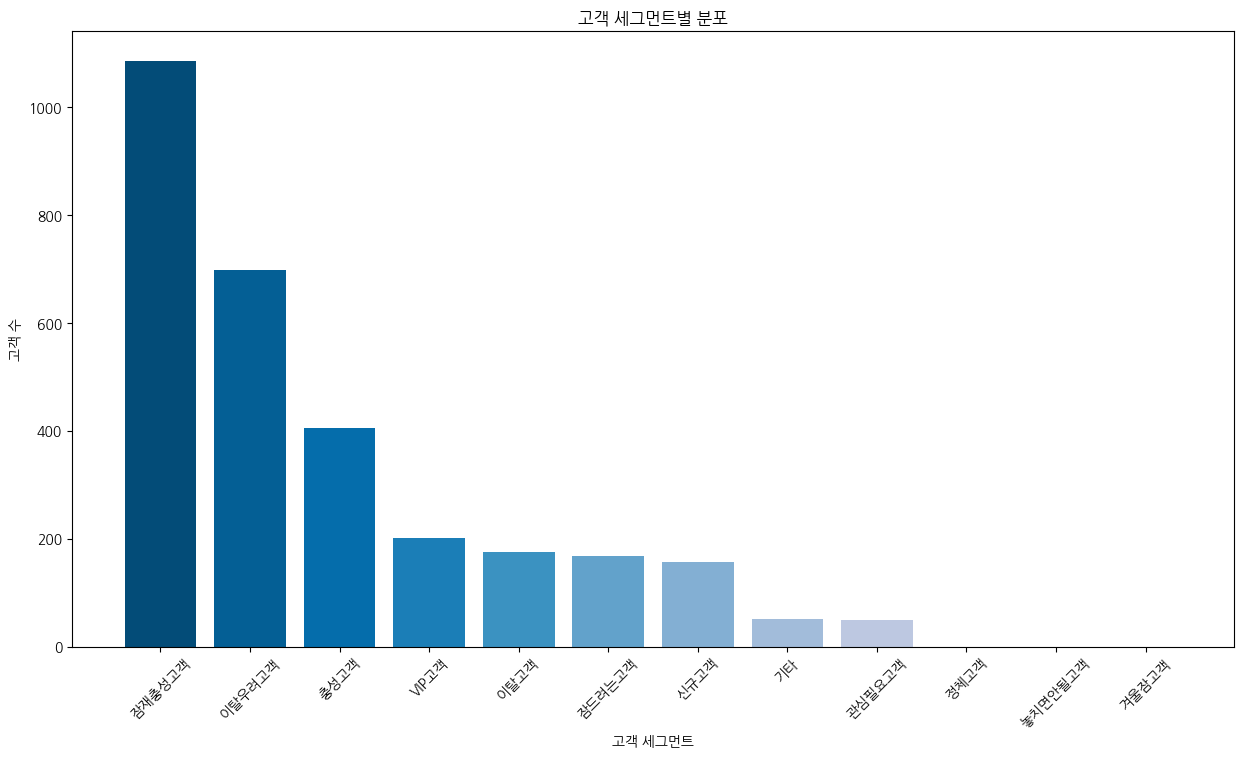

In [18]:
# 세그먼트별 고객 수를 내림차순으로 정렬
segment_counts_sorted_df = segment_counts_df.sort_values(by='Count', ascending=False)

palette = sns.color_palette('PuBu',  len(segment_counts_sorted_df))
palette.reverse()

# 바 그래프 시각화
plt.figure(figsize=(15, 8))
plt.bar(segment_counts_sorted_df['Segment'], segment_counts_sorted_df['Count'], color=palette)
plt.title('고객 세그먼트별 분포')
plt.xlabel('고객 세그먼트')
plt.ylabel('고객 수')
plt.xticks(rotation=45)
plt.show()



In [19]:
rfm_data

,idUser,OrderDT,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,U10001,2023-12-27 08:25:54,4,69,5968480,4,4,4,444,VIP고객
1,U10002,2023-12-06 10:16:48,25,54,4595890,1,2,1,121,기타
2,U10003,2023-12-23 21:09:58,8,53,5110930,3,2,2,322,잠재충성고객
3,U10004,2023-12-05 20:24:04,26,33,2641890,1,1,1,111,이탈고객
4,U10005,2023-11-20 12:40:36,41,79,6920530,1,4,4,144,이탈우려고객
...,...,...,...,...,...,...,...,...,...,...
2995,U12996,2023-12-29 18:56:12,2,20,2256990,4,1,1,411,잠재충성고객
2996,U12997,2023-12-26 20:27:53,5,67,5999100,3,3,4,334,충성고객
2997,U12998,2023-11-27 19:51:55,34,56,5318240,1,2,3,123,이탈우려고객
2998,U12999,2023-12-27 10:22:26,4,55,5321330,4,2,3,423,잠재충성고객


In [20]:
# df = pd.merge(order_user_item, rfm_data[['idUser','Customer_Segment']])

df =pd.merge(rfm_data[['idUser','Customer_Segment']], order_user_item[['idUser','MemberYN']])
df.drop_duplicates('idUser', inplace=True)

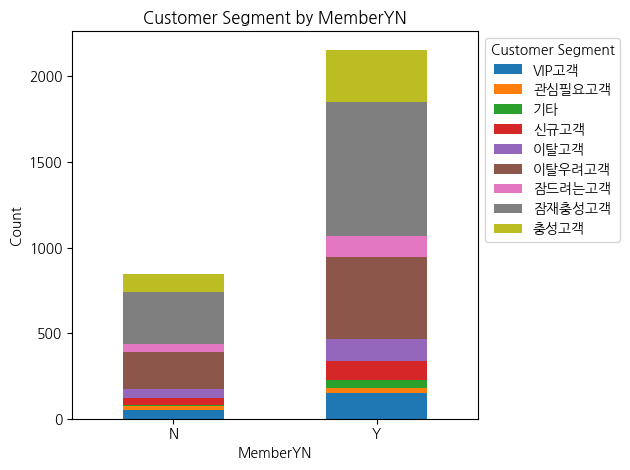

In [21]:
# MemberYN 별 Customer_Segment 빈도 계산
segment_counts = df.groupby(['MemberYN', 'Customer_Segment']).size().unstack()

# 그래프 그리기
segment_counts.plot(kind='bar', stacked=True)
plt.title('Customer Segment by MemberYN')
plt.xlabel('MemberYN')
plt.ylabel('Count')
plt.xticks(rotation=0)  # x축 레이블 회전
plt.legend(title='Customer Segment', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [22]:
segment_counts

Customer_Segment,VIP고객,관심필요고객,기타,신규고객,이탈고객,이탈우려고객,잠드려는고객,잠재충성고객,충성고객
MemberYN,,,,,,,,,
N,53,19,10,41,52,215,46,305,104
Y,149,32,43,116,124,483,123,782,303
